In [ ]:
import os
import time
import h5py
import scipy
import timeit
import pyfftw
import numpy as np 
import matplotlib.pyplot as plt  
import matplotlib.ticker as mticker

from scipy.fft import fftfreq, fftn, ifftn
from matplotlib import animation
from scipy.special import k0, k1
from tqdm.notebook import tqdm
from tqdm import tqdm
from scipy.interpolate import RegularGridInterpolator, interpn
from matplotlib.animation import FuncAnimation 
from matplotlib.animation import PillowWriter
from matplotlib.animation import FFMpegWriter

from ULDM_Simulator import *

plt.rcParams['text.usetex'] = True
plt.style.use('./myplot.mplstyle')

# Free Ultralight Dark Matter

In [14]:
sim = ULDM_Simulator(L=32, kJ=1e-3)
sim.solve()

  0%|          | 0/4096 [00:00<?, ?it/s]

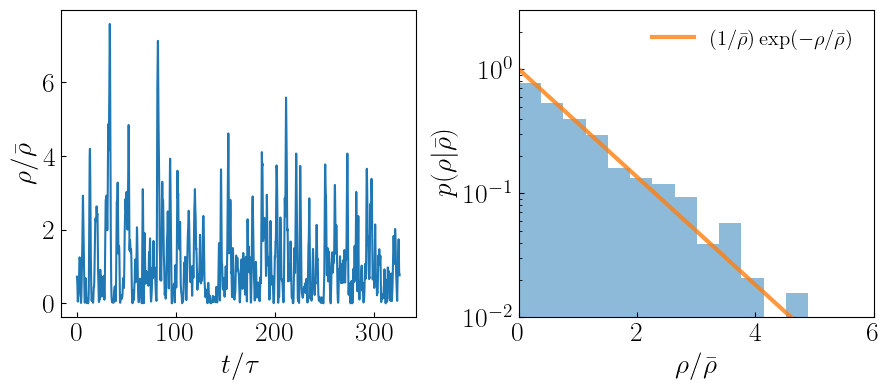

In [62]:
fig, ax = plt.subplots(ncols=2, figsize=(9,4))

ax[0].plot(sim.time, sim.rho)
ax[0].set_xlabel(r'$t/\tau$');
ax[0].set_ylabel(r'$\rho/\bar\rho$');


ax[1].hist(sim.rho[::4],
           density=True,
           bins=20,
           alpha=0.5)

rho_arr = np.arange(0,10,0.1)
ax[1].plot(rho_arr, np.exp(-rho_arr),
           linewidth=3,
           alpha=0.8,
           label=r'$(1/\bar\rho)\exp(-\rho/\bar\rho)$')

ax[1].set_xlim(0, 6)
ax[1].set_ylim(1e-2, 3)
ax[1].set_yscale('log')

ax[1].set_xlabel(r'$\rho/\bar\rho$');
ax[1].set_ylabel(r'$p(\rho |\bar\rho)$');
ax[1].legend()

fig.tight_layout()
fig.savefig('./figs/ULDM_density_fluctution.pdf')

In [574]:
class Utility():
    '''
    TODO::
    Examine numerical coefficients of analytic spectrum
    '''

    def __init__(self, sim_data):
        self.data = sim_data
        self.pos_arr = self.data.pos_arr
        self.vel_arr = self.data.vel_arr
        self.acc_arr = self.data.acc_arr
        self.time = self.data.time
        self.T = self.data.T
        self.dt = self.data.dt
        self.kJ = self.data.kJ

    def plot_PS(self, 
                window=[True,False], 
                each=[False,False],
                alpha=0.5,
                subtracted=False,
                ):
        '''
        Plot Power Spectrum and
        Compare with analytic result
        '''
        if not subtracted:
            x = self.pos_arr[:, 0]
            y = self.pos_arr[:, 1]
            z = self.pos_arr[:, 2]

            ax = self.acc_arr[:, 0]
            ay = self.acc_arr[:, 1]
            az = self.acc_arr[:, 2]
        else:
            x = self.data.x_sub
            y = self.pos_arr[:, 1]
            z = self.pos_arr[:, 2]
            ax = self.data.a_sub
            ay = self.acc_arr[:, 1]
            az = self.acc_arr[:, 2]

        if window[0]:
            window_func = np.sin(np.pi * self.time / self.T)**8 * (128/35)
            x = x * window_func
            y = y * window_func
            z = z * window_func
            
        if window[1]:
            window_func = np.sin(np.pi * self.time / self.T)**8 * (128/35)
            ax = ax * window_func
            ay = ay * window_func
            az = az * window_func
        
        self.ps_x = (self.dt**2 / self.T) * np.abs(fftn(x))**2
        self.ps_z = (self.dt**2 / self.T) * np.abs(fftn(y))**2
        self.ps_y = (self.dt**2 / self.T) * np.abs(fftn(z))**2

        self.ps_ax = (self.dt**2 / self.T) * np.abs(fftn(ax))**2
        self.ps_ay = (self.dt**2 / self.T) * np.abs(fftn(ay))**2
        self.ps_az = (self.dt**2 / self.T) * np.abs(fftn(az))**2
        
        self.freq = fftfreq(len(self.time), self.dt)
        
        n = len(self.time)//2

        fig, ax = plt.subplots(ncols=2, figsize=(9,4))

        avg_PS_x = (self.ps_x[:n] + self.ps_y[:n] + self.ps_z[:n]) / 3
        avg_PS_a = (self.ps_ax[:n] + self.ps_ay[:n] + self.ps_az[:n]) / 3
        
        if each[0]:
            ax[0].plot(self.freq[:n], self.ps_x[:n], 'x', alpha=alpha, label=r'$x$')
            ax[0].plot(self.freq[:n], self.ps_y[:n], '+', alpha=alpha, label=r'$y$')
            ax[0].plot(self.freq[:n], self.ps_z[:n], '.', alpha=alpha, label=r'$z$')
            ax[0].legend()
        else:
            ax[0].plot(self.freq[:n], avg_PS_x, '.')
        ax[0].plot(self.freq[:n], self.Sx(self.freq[:n]), lw=5, alpha=0.5)
        ax[0].set_xscale('log')
        ax[0].set_yscale('log')
        ax[0].set_xlabel(r'$\textrm{Frequency [Hz]}$')
        ax[0].set_ylabel(r'${\rm PSD}_x$')
        ax[0].set_ylim(max(1e-3 * min(avg_PS_x), self.Sx(5)), 10 * max(avg_PS_x))

        if each[1]:
            ax[1].plot(self.freq[:n], self.ps_ax[:n], 'x', alpha=alpha, label=r'$a_x$')
            ax[1].plot(self.freq[:n], self.ps_ay[:n], '+', alpha=alpha, label=r'$a_y$')
            ax[1].plot(self.freq[:n], self.ps_az[:n], '.', alpha=alpha, label=r'$a_z$')
            ax[1].legend()
        else:
            ax[1].plot(self.freq[:n], avg_PS_a, '.')
        ax[1].plot(self.freq[:n], self.Sa(self.freq[:n]), lw=5, alpha=0.5)
        ax[1].set_xscale('log')
        ax[1].set_yscale('log')
        ax[1].set_xlabel(r'$\textrm{Frequency [Hz]}$')
        ax[1].set_ylabel(r'${\rm PSD}_a$')
        ax[1].set_ylim(max(1e-3 * min(avg_PS_a), self.Sa(5)), 10 * max(avg_PS_a))
        
        fig.tight_layout()
        return fig;

    def Sa(self, f: list[float]):
        '''
        Analytic spectrum S_a(f)
        Input
            f (ndarray (n,))    frequency array
        '''

        # In this simulation we measure time in coherence time
        # and frequency in inverse of coherence time
        tau = 1
        return (self.kJ**8 / 16) * k0(np.abs(2 * np.pi * f * tau)) * tau / 3
    
    def Sx(self, f: list[float], f0=0):
        '''
        Analytic spectrum S_x(f)
        Input
            f (ndarray (n,))    frequency array
        '''

        # In this simulation we measure time in coherence time
        # and frequency in inverse of coherence time
        tau = 1 
        return self.Sa(f) / (2 * np.pi * (f + f0) * tau)**4

In [66]:
sim_FP = ULDM_FreeParticle(L=32, kJ=1e-3)

In [67]:
sim_FP.solve()

100%|██████████| 4096/4096 [04:57<00:00, 13.76it/s]


In [563]:
util = Utility(sim_FP)

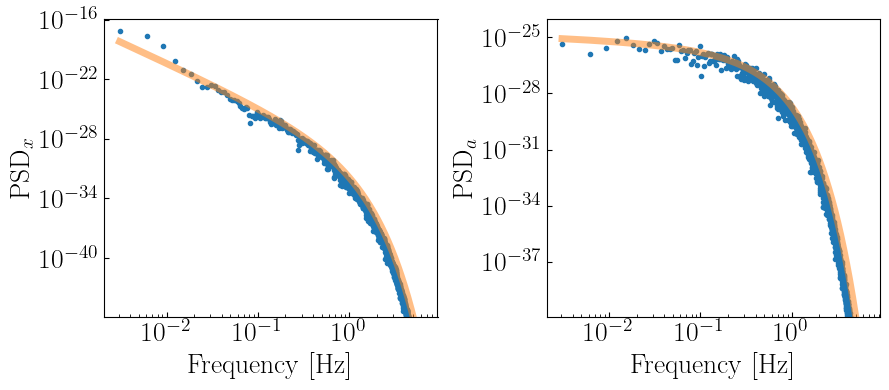

In [564]:
fig = util.plot_PS(window=[True,False]);
# fig.savefig('./figs/freeParticlePSD.pdf')

In [ ]:
class ULDM_HarmonicOscillator(ULDM_Simulator):
    def __init__(self, f_osc, dist='Iso_Gaussian', L=5, N=64, kJ=1e-3):
        super().__init__(dist=dist, L=L, N=N, kJ=kJ)
        self.f_osc = f_osc
        self.set_initial_kinematics()
        self.time = np.arange(0, self.T, self.dt)

    def set_initial_kinematics(self):
        self.grid = np.linspace(-self.L/2, self.L/2, self.N)

        self.ax = np.real(ifftn(-1j * self.KX * self.Phi_fourier))
        self.ay = np.real(ifftn(-1j * self.KY * self.Phi_fourier))
        self.az = np.real(ifftn(-1j * self.KZ * self.Phi_fourier))

        self.pos = np.array([1, 0, 0])
        self.vel = np.array([0, 0, 0])

        self.acc = np.array([interpn(self.coordinate, self.ax, self.pos)[0] - (2 * np.pi * self.f_osc)**2 * self.pos[0],
                             interpn(self.coordinate, self.ay, self.pos)[0],
                             interpn(self.coordinate, self.az, self.pos)[0]])

    # THIS OVERRIDES evolve METHOD IN PARENT CLASS
    def evolve(self):
        '''
        Evolve field according to kick-drift-kick scheme
        Evolve particle according to drift-kick-drift (leapfrog)
        '''
        
        # Initial kick - drift sequence
        self.psi *= np.exp(-0.5j * self.Phi * self.dt)
        self.psi = fftn(self.psi)
        self.psi *= np.exp(-0.5j * self.K2 * self.dt)   
        self.psi = ifftn(self.psi)

        # Update Phi and acceleration
        self.rhob = self.N**(-3) * np.sum(np.abs(self.psi)**2)
        
        self.Phi_fourier = fftn(-(self.kJ**4 / 4) * (np.abs(self.psi)**2 - self.rhob)) * self.invK2
        self.Phi = np.real(ifftn(self.Phi_fourier))
        
        self.ax = np.real(ifftn(-1j * self.KX * self.Phi_fourier))
        self.ay = np.real(ifftn(-1j * self.KY * self.Phi_fourier))
        self.az = np.real(ifftn(-1j * self.KZ * self.Phi_fourier))
        
        self.psi *= np.exp(-0.5j * self.Phi * self.dt)
        
        def force(pos):
            return np.array([interpn(self.coordinate, self.ax, pos)[0],
                             interpn(self.coordinate, self.ay, pos)[0],
                             interpn(self.coordinate, self.az, pos)[0]]) + self.harmonic_force(pos)

        # For free particle evolution
        self.pos, self.vel, self.acc = self.yoshida(self.pos, self.vel, force)
        
    def leapfrog(self, pos, vel, force):
        '''
        Leapfrog integrator
        '''
        dt = self.dt
        
        x = pos + 0.5 * vel * dt
        v = vel + force(x) * dt
        x = x + 0.5 * v * dt

        return x, v, force(x)

    def yoshida(self, pos, vel, force):
        '''
        4th order Yoshida integrator
        '''
        dt = self.dt

        w0 = - 2**(1 / 3) / (2 - 2**(1 / 3))
        w1 = 1 / (2 - 2**(1/3))
        c1 = c4 = w1 / 2
        c2 = c3 = (w0 + w1) / 2
        d1 = d3 = w1
        d2 = w0

        x1 = pos + c1 * vel * dt
        v1 = vel + d1 * force(x1) * dt
        
        x2 = x1 + c2 * v1 * dt
        v2 = v1 + d2 * force(x2) * dt
        
        x3 = x2 + c3 * v2 * dt
        v3 = v2 + d3 * force(x3) * dt

        x4 = x3 + c4 * v3 * dt
        v4 = v3

        return x4, v4, force(x4)

    def harmonic_force(self, pos):
        return np.array([-(2 * np.pi * self.f_osc)**2 * pos[0], 0, 0])

    # THIS OVERRIDES solve METHOD IN PARENT CLASS
    def solve(self, save=True):
        if save == True:
            self.rho = np.zeros(len(self.time))
            self.pos_arr = np.zeros((len(self.time), 3))
            self.vel_arr = np.zeros((len(self.time), 3))
            self.acc_arr = np.zeros((len(self.time), 3))

            for i, _ in enumerate(tqdm(self.time)):
                self.rho[i] = (np.abs(self.psi)**2)[0,0,0]
                self.pos_arr[i] = self.pos
                self.vel_arr[i] = self.vel
                self.acc_arr[i] = self.acc
                self.evolve()

    def subtract(self, truth=True):
        '''
        Subtracting motion due to haronic force
        Input
            truth (bool)    if true, subtraction done by prior knowledge of injected force
        '''
        if truth:
            self.x_sub = self.pos_arr[:,0] - np.cos(2 * np.pi * self.f_osc * self.time)
            self.a_sub = self.acc_arr[:,0] + (2 * np.pi * self.f_osc)**2 * self.pos_arr[:,0]

In [526]:
sim_HO = ULDM_HarmonicOscillator(L=32, kJ=1e-3, f_osc=2e-1)
sim_HO.solve()

100%|██████████| 4096/4096 [04:26<00:00, 15.37it/s]


In [546]:
sim_HO.subtract()

In [624]:
plot_HO = Utility(sim_HO)

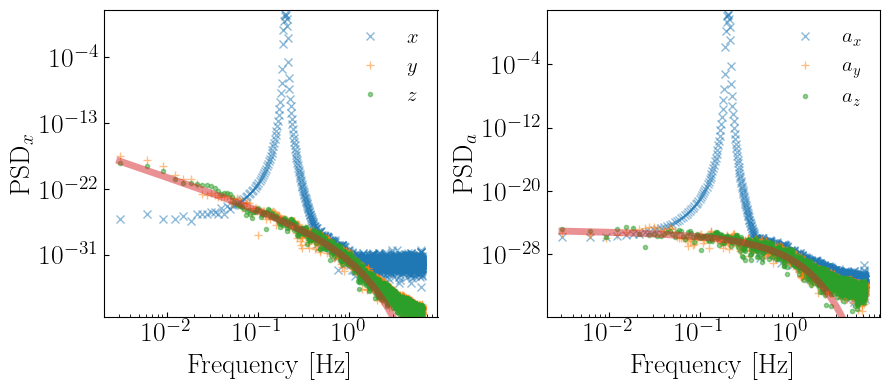

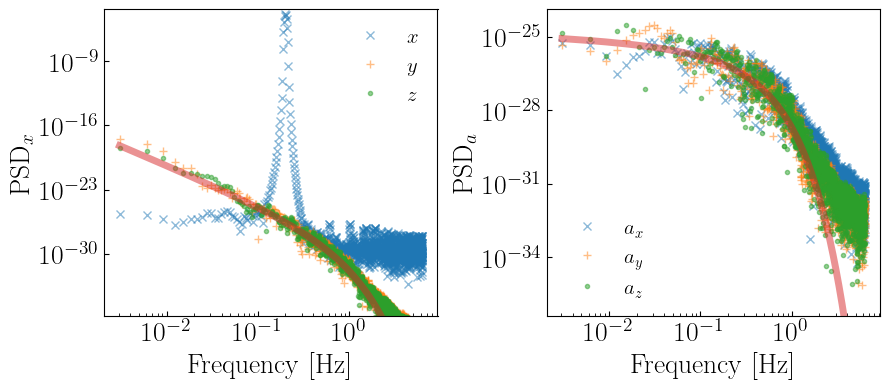

In [627]:
fig = plot_HO.plot_PS(window=[True,True],
                      each=[True,True],
                      subtracted=False);

fig.savefig('./figs/SHO_before_subtraction.pdf')

fig = plot_HO.plot_PS(window=[True,True],
                      each=[True,True],
                      subtracted=True);

fig.savefig('./figs/SHO_after_subtraction.pdf')

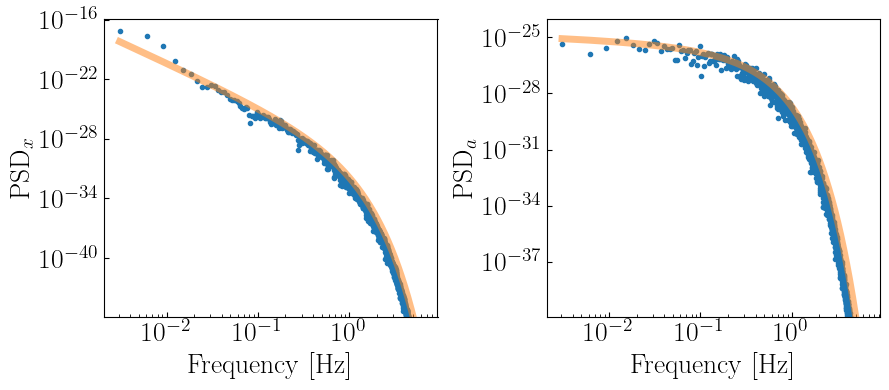

In [626]:
fig

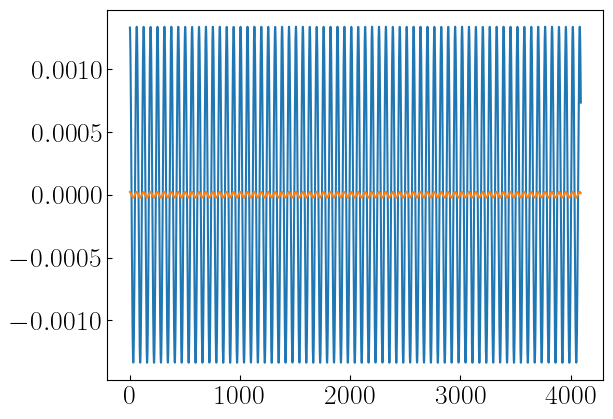

In [659]:
acc_from_pos0 = np.array([sim_HO.pos_arr[i+1,0] - 2 * sim_HO.pos_arr[i,0] + sim_HO.pos_arr[i-1,0] for i in range(1, len(sim_HO.time)-1)]) / (sim_HO.dt**2)
acc_from_pos = np.array([sim_HO.pos_arr[i+1,0] - 2 * sim_HO.pos_arr[i,0] + sim_HO.pos_arr[i-1,0] for i in range(1, len(sim_HO.time)-1)]) / (sim_HO.dt**2)
acc_from_pos = acc_from_pos + (2 * np.pi * sim_HO.f_osc)**2 * sim_HO.pos_arr[1:-1,0]
# plt.plot(sim_HO.acc_arr[:,0])

acc_from_pos2 = np.array([- 1 / 12 * sim_HO.pos_arr[i+2,0] 
                          + 4 / 3 * sim_HO.pos_arr[i+1,0] 
                          - 5 / 2 * sim_HO.pos_arr[i,0] 
                          + 4 / 3 * sim_HO.pos_arr[i-1,0] 
                          - 1 / 12 * sim_HO.pos_arr[i-2,0] for i in range(2, len(sim_HO.time)-2)]) / (sim_HO.dt**2)
acc_from_pos2 = acc_from_pos2 + (2 * np.pi * sim_HO.f_osc)**2 * sim_HO.pos_arr[2:-2,0]

plt.plot(acc_from_pos)
plt.plot(acc_from_pos2)

In [653]:
wd = np.sin(np.pi * sim_HO.time / (sim_HO.T))**8 * (128/35)
wd1 = np.sin(np.pi * sim_HO.time[1:-1] / (sim_HO.T - sim_HO.dt * 2))**8 * (128/35)
wd2 = np.sin(np.pi * sim_HO.time[2:-2] / (sim_HO.T - sim_HO.dt * 4))**8 * (128/35)
pre = (sim_HO.dt**2 / sim_HO.T)

freq = fftfreq(len(sim_HO.time), sim_HO.dt)

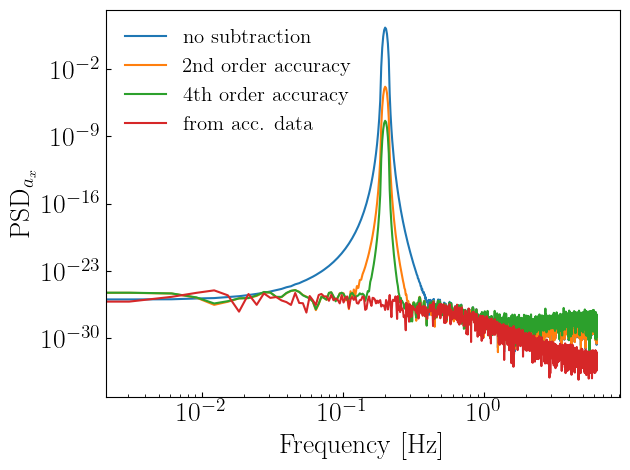

In [ ]:
fig, ax = plt.subplots()

ax.plot(freq[:len(acc_from_pos0)//2], pre * (np.abs(fftn(acc_from_pos0*wd1))**2)[:len(acc_from_pos0)//2],
        label=r'\textrm{no subtraction}')
ax.plot(freq[:len(acc_from_pos)//2], pre * (np.abs(fftn(acc_from_pos*wd1))**2)[:len(acc_from_pos)//2],
        label=r'\textrm{2nd order accuracy}')
ax.plot(freq[:len(acc_from_pos2)//2], pre * (np.abs(fftn(acc_from_pos2*wd2))**2)[:len(acc_from_pos2)//2],
        label=r'\textrm{4th order accuracy}')
ax.plot(freq[:len(acc_from_pos)//2], pre * (np.abs(fftn(sim_HO.a_sub))**2)[:len(acc_from_pos)//2],
        label=r'\textrm{from acc. data}')

ax.set_xlabel(r'$\textrm{Frequency [Hz]}$')
ax.set_ylabel(r'$\textrm{PSD$_{a_x}$}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

fig.tight_layout()
# fig.savefig('./figs/SHO_fd.pdf')